# Using Dynamical Decoupling (DD)

Dynamical Decoupling (DD) is an effective error-suppression technique used to suppress errors in quantum computers. Here, we’ll explain (in basic terms) the technique behind DD, how it works, and how you can leverage IQM’s API to implement DD sequences on your quantum circuits when executing them on IQM’s quantum computers via cloud. 

DD sequences typically consist of a series of π-pulses (180-degree rotations) applied to the qubits. These pulses are designed to refocus the qubit’s state, effectively canceling out, for example, the accumulated phase errors (Z and ZZ errors, for instance). Common DD sequences available as default sequences via IQM's cloud API include: 
- XX: A simple sequence of two π-pulses. This is also known as CPMG pulses. 
- YXYX: A sequence that alternates between X and Y pulses.
-  XYXYYXYX: A longer sequence.
  

In this notebook, you will learn how to

* ... apply the standard DD sequences on your quantum circuits.
* ... customize your DD sequences.
* ... build your own DD sequences. 

By the end of this notebook, you will be able to execute your quantum circuits with our standard as well as your chosen DD sequences to squeeze the maximum performance out of our quantum computers.
## Installing the necessary packages
In order to get started, make sure you have the appropriate packages installed: 

In [1]:
%%capture
!pip install "iqm-client[qiskit] >= 32.1.1, < 33.0"
!pip install "qrisp[iqm]"

## Connecting to IQM Garnet

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable). Let's first check that our connection is working. We can do this by authenticating ourselves to IQM Resonance.

In [1]:
from qrisp.interface import IQMBackend


# Create a backend object
quantum_computer = IQMBackend(api_token = input("Enter your IQM Resonance API token: "), 
                          device_instance = "sirius",)


/Users/see/dev/iqm-academy-second-try/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/see/dev/iqm-academy-second-try/.venv/lib/python3.11/site-packages/iqm/iqm_client/iqm_client.py:147: UserWarning: Your IQM Client version 30.2.0 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 32.1.1 <= iqm-client < 33.0.
  warnings.warn(version_incompatibility_msg)


# Imports

Let us now import relevant modules necessary for this tutorial. For instance, it is important to import *CircuitCompilationOptions*, *DDMode*, and *DDStrategy*. Because DD operates at a lower compilation stage, at the so-called "time-box" representation of Qiskit instructions, it is important to import *CircuitCompilationOptions*. *DDMode* and *DDStrategy* are other classes that allow one to turn the DD on or off and specify a given DD pulse sequence and its alignment.

In [3]:
# General
import numpy as np

# qrisp
from qrisp import *

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 500

# IQM Client
from iqm.iqm_client.models import CircuitCompilationOptions
from iqm.iqm_client.models import DDMode, DDStrategy

# Choose qubits pair

Let us now choose a qubit pair. In our example circuit, defined on the next cell, there is a DD qubit (called dd_qubit) and control qubit (called ctrl_qubit). We add a control qubit in our circuit because it allows one to easily create delays on the DD qubit by appropriately positioning the barriers. 

**Task: Select two qubits (e.g. "QB3", "QB4") and add them to the code below. Check the Resonance page to find two neighboring qubits**

In [ ]:
dd_qubit = 0
ctrl_qubit = 1

qubits = ['QB3', 'QB4'] # Choose two qubits
ini_layout = [int(s[2:]) - 1 for s in qubits]
print(f"Initial layout is: {ini_layout}")

Initial layout is: [2, 3]


# Define the example circuit to apply DD on

As an example of DD applied to a single qubit that is idling, we consider a Ramsey-like circuit, called a quantum memory circuit, following Fig. 1 of Ref. [1]. A quantum memory experiment specifically involves preparing a superposition state, waiting for a period, and then reversing the initial operation to assess coherence preservation. During the wait period (also known as the idle period), when no gates are being applied to the qubit, the qubit might accumulate errors due to, for example, a mis-aligned drive frame or residual ZZ interaction. The idea behind this circuit is to see if the coherence loss due to those error mechanisms can be avoided as a result of applying DD pulses during the wait period. The function below generates the example circuit:

In [22]:
def r(theta, phi, qubit):
    """
    Implements the RGate(theta, phi) in Qrisp.

    Parameters
    ----------
    theta : float
        Rotation angle.
    phi : float
        Axis angle in XY plane.
    qubit : Qubit or QuantumVariable
        Target qubit.
    """
    rz(phi, qubit)
    rx(theta, qubit)
    rz(-phi, qubit)
    return qubit

def quantum_memory_circuit(num_id_gates: float):
    """
    Generates a quantum memory circuit with variable delay for the data qubit (dd_qubit) 
    using multiple identity gates on the control qubit (ctrl_qubit). Adding identity gates
    to neighboring qubit (ctrl_qubit) and methodically adding barriers to the circuit will create 
    idlings in the dd_qubit. 
    
    Args:
        num_id_gates: number of identity (or zero angle gates typically of 20 ns duration) to be added in neighboring qubit.
    Returns:
        a transpiled circuit.
    """
    qv = QuantumVariable(1)
    ancilla = QuantumVariable(1)
    r(-np.pi/2, -np.pi/2, qv)
    r(np.pi, np.pi/4, qv)
    barrier(qv)  # giant barrier through both qubits
    for _ in range(num_id_gates):
        r(0, 0, ancilla)  # add zero angle or identity gates to methodically allow for delay to be added to DD qubit
        barrier(ancilla)  # single barrier for qubit 1
    barrier(qv)
    r(-np.pi/2, 0, qv)
    r(np.pi, np.pi/4, qv)
    measure(qv)  # PFR: REPLACED measure_all TO MEASURING ONLY THE IDLING QUBIT!
    
    return qv
    
#Draw the transpiled circuit
qc = quantum_memory_circuit(3).qs.compile()
print(qc)

      ┌──────────┐┌──────────┐┌──────────┐┌───────┐┌──────────┐┌──────────┐»
qv.0: ┤ Rz(-π/2) ├┤ Rx(-π/2) ├┤ Rz(3π/4) ├┤ Rx(π) ├┤ Rz(-π/4) ├┤ Rx(-π/2) ├»
      └──────────┘└──────────┘└──────────┘└───────┘└──────────┘└──────────┘»
cb_0: ═════════════════════════════════════════════════════════════════════»
                                                                           »
«      ┌─────────┐┌───────┐┌──────────┐┌────────┐┌─┐
«qv.0: ┤ Rz(π/4) ├┤ Rx(π) ├┤ Rz(-π/4) ├┤ gphase ├┤M├
«      └─────────┘└───────┘└──────────┘└────────┘└╥┘
«cb_0: ═══════════════════════════════════════════╩═
«                                                   


# Submit jobs with and without DD

To create our circuits of interest, we sweep the number of zero-angle single-qubit gates (SQG) on the control qubit. Depending on the number of these gates, increasingly longer delays are created on the control qubit. The typical duration of our SQG is 20 ns. Therefore, the duration of delays is just going to be the number of gates multiplied by 20 ns. We can now run our circuits with and without DD as we do in Qiskit, but if one wants to run circuits with DD, one now additionally provides a flag for DD to be operational when submitting the circuits, as shown below. When using DD in such a default way, the API automatically chooses the so-called standard strategy. Under the standard strategy, the three DD sequences introduced in the introduction are automatically placed by looking at idles that have fitting sizes. For example, if the idles are short (i.e., three times the duration of the X gate), the XX sequence is symmetrically placed. If the idles are longer than eight times the duration of the X gate, the XYXYYXYX sequence is placed accordingly.

**TASK: Set a meaningful list of identity / r(0,0) gates to be added to the control qubit in `length_array`.**

In [ ]:
token = input("Enter your IQM Resonance API token: ")
length_array = [1,5,10,20] # Define a meaningful list of identity / r(0,0) gates to be added to the control qubit
qc_list = []

for idx, length in enumerate(length_array):
    qc_list.append(quantum_memory_circuit(length))
    print("",f"Now generating circuit {idx+1}/{len(length_array)}",end="\r")

shots = 2**10

print("\nSubmitting DD")
from qrisp.interface import IQMBackend
quantum_computer_dd = IQMBackend(api_token = token, 
                          device_instance = "garnet",
                          compilation_options = CircuitCompilationOptions(dd_mode=DDMode.ENABLED))

job_dd = []
for qv in qc_list:
    job_dd.append(qv.get_measurement(backend = quantum_computer_dd))

print("Submitting Bare")

quantum_computer_bare = IQMBackend(api_token = token, 
                          device_instance = "garnet",
                          compilation_options = CircuitCompilationOptions(dd_mode=DDMode.DISABLED))
job_bare = []
for qv in qc_list:
    job_bare.append(qv.get_measurement(backend = quantum_computer_bare))



 Now generating circuit 4/4
Submitting DD


/Users/see/dev/iqm-academy-second-try/.venv/lib/python3.11/site-packages/iqm/iqm_client/iqm_client.py:147: UserWarning: Your IQM Client version 30.2.0 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 32.1.1 <= iqm-client < 33.0.
  warnings.warn(version_incompatibility_msg)


Submitting Bare


/Users/see/dev/iqm-academy-second-try/.venv/lib/python3.11/site-packages/iqm/iqm_client/iqm_client.py:147: UserWarning: Your IQM Client version 30.2.0 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 32.1.1 <= iqm-client < 33.0.
  warnings.warn(version_incompatibility_msg)


# Retrieve counts and plot for standard strategy

Retrieving DD
Retrieving Bare


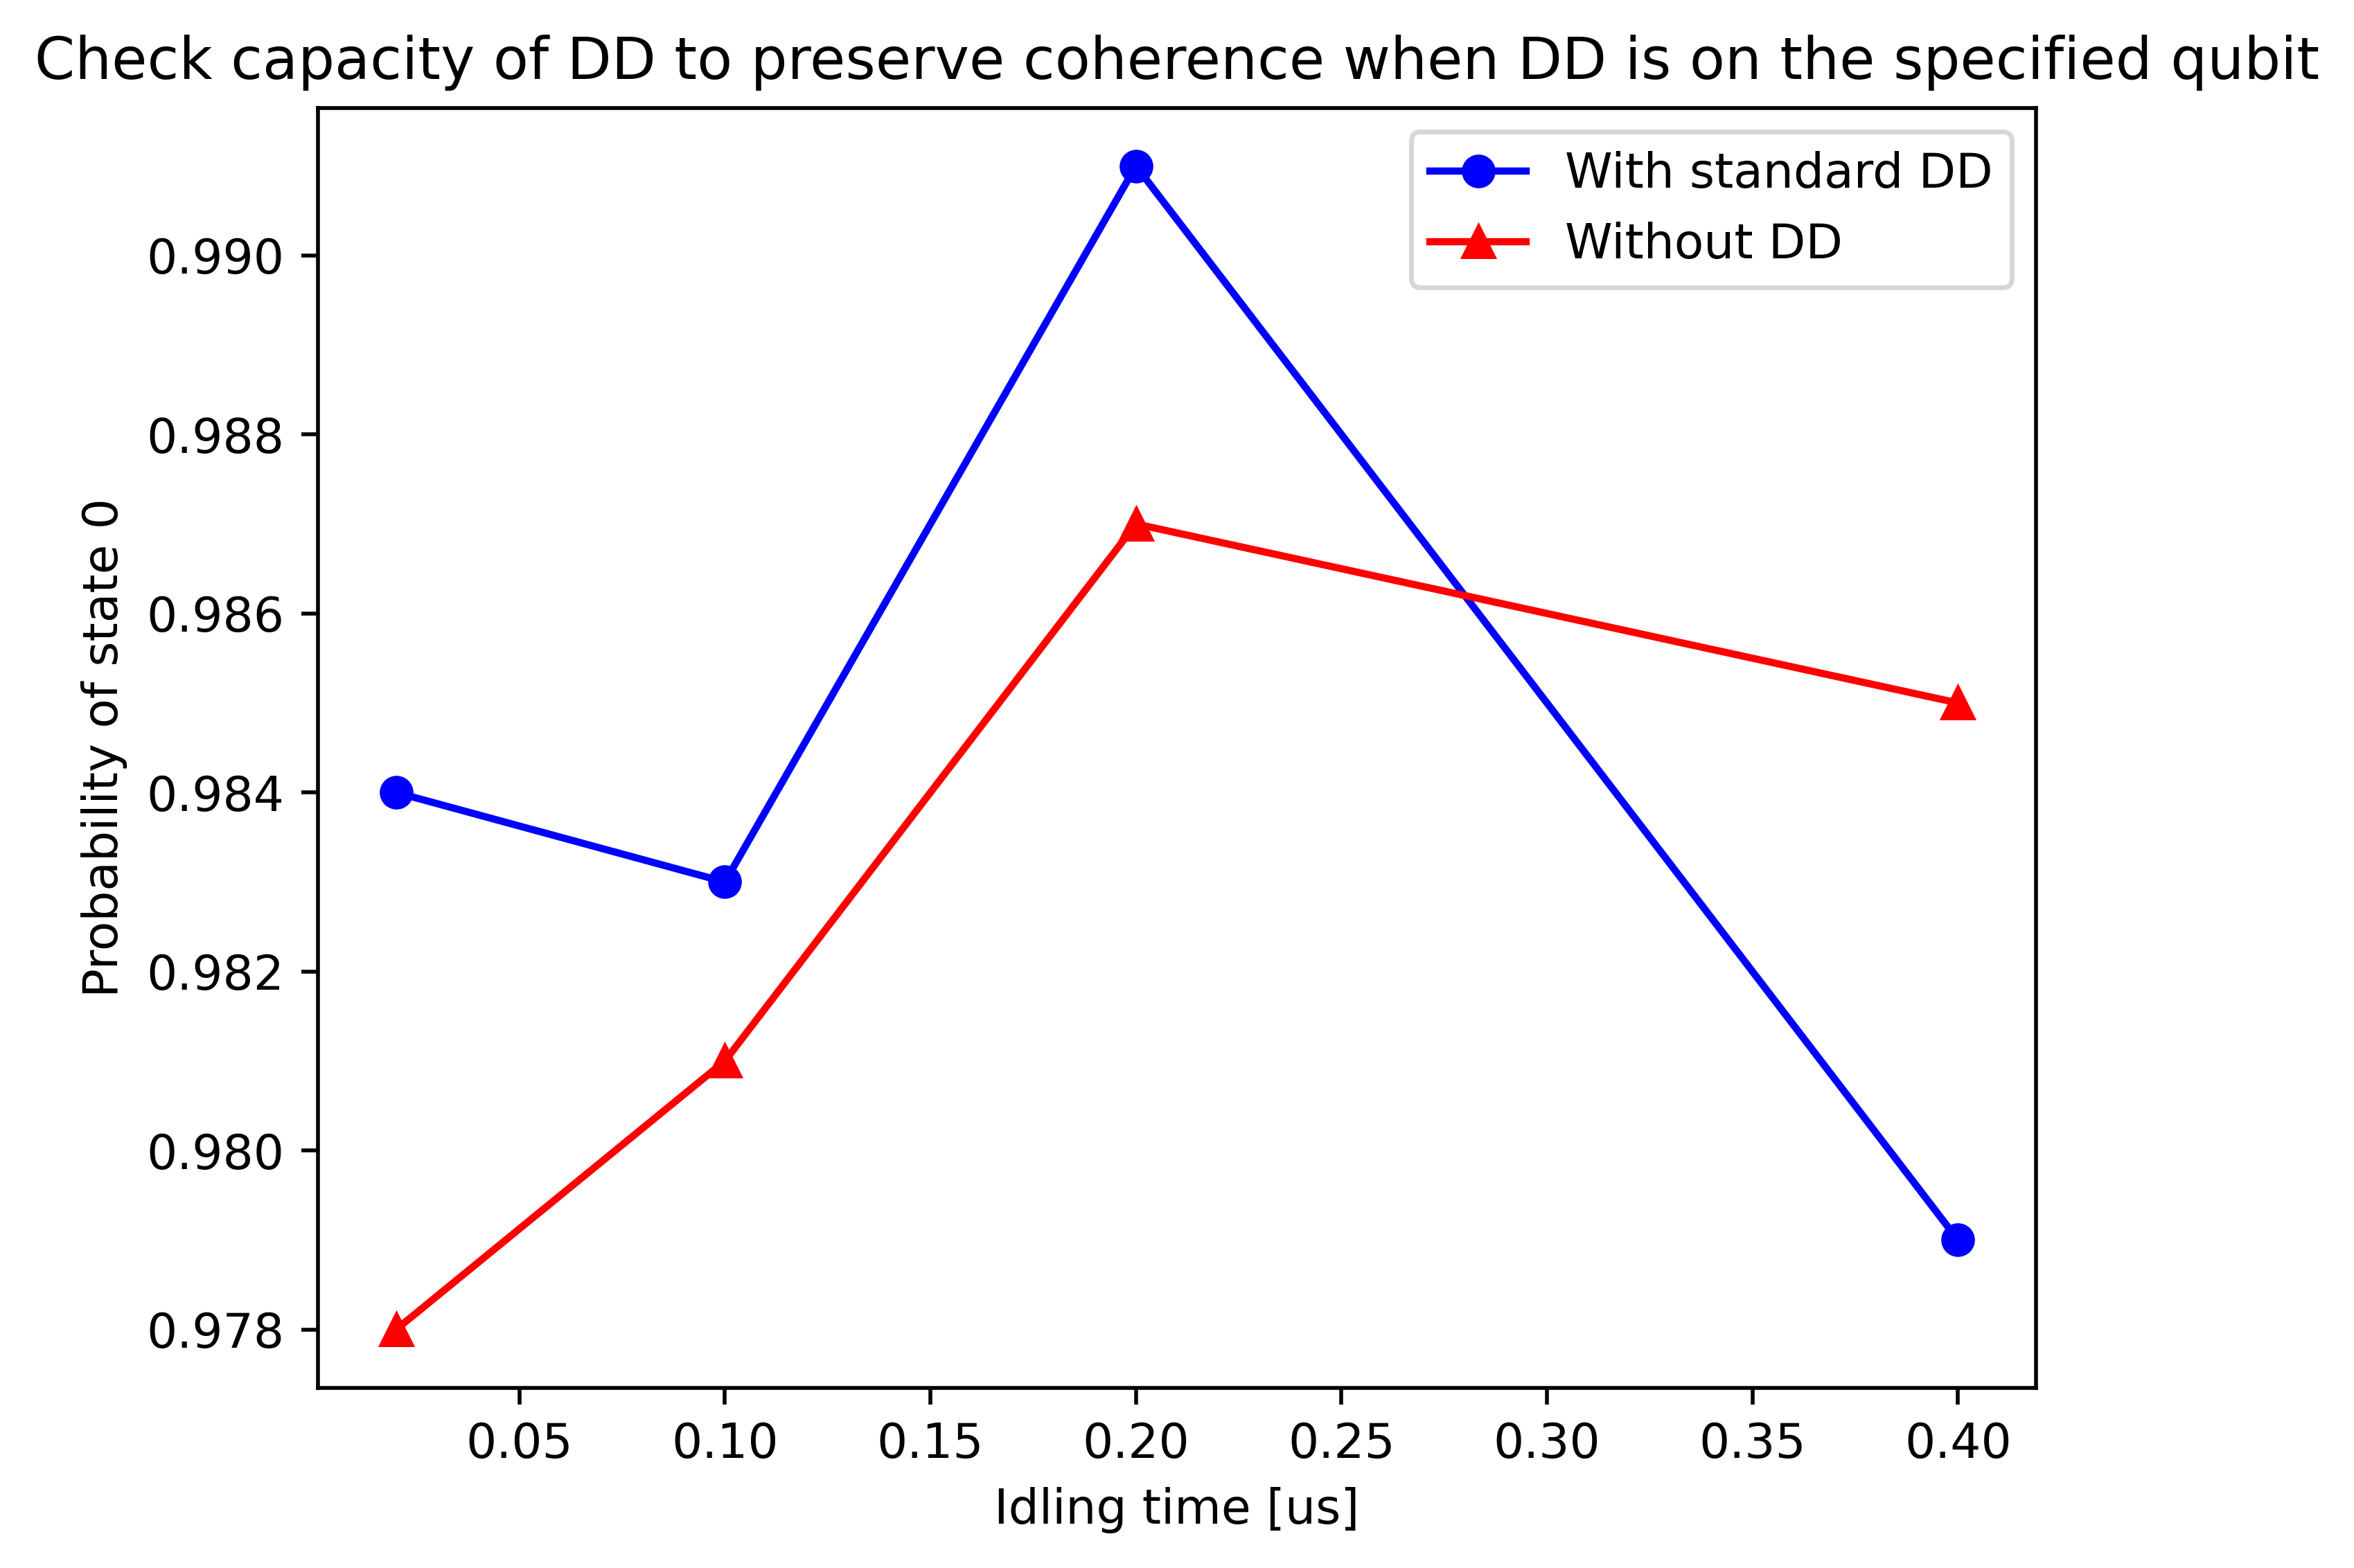

In [29]:
print("Retrieving DD")
prob_dd = [x['0'] for x in job_dd]

print("Retrieving Bare")
prob_bare = [x['0'] for x in job_bare]

time_array = np.array(length_array)*20/1e3 #Since our SQG duration is 20 ns each, let us nicely write the x-axis values. 

plt.plot(time_array, prob_dd, 'bo-', label="With standard DD")
plt.plot(time_array, prob_bare, 'r^-', label="Without DD")
plt.xlabel("Idling time [us]")
plt.ylabel("Probability of state 0")
plt.title("Check capacity of DD to preserve coherence when DD is on the specified qubit")
plt.legend()
plt.show()

**Task: What does the plot above suggest about the effect of DD pulses on the survival probability?**

# Now let us customize DD sequences

One can also customize DD sequences. If one wants to apply just the XX sequence, for example, on all the idles that have durations larger than twice the duration of a single-qubit gate, one can define a custom XX strategy. We define below a custom strategy for XX, and YXYX sequences.

**Task: Create a custom strategy for the DD sequences. Compare the performance of the standard and custom strategies.**

In [ ]:
comp_options_xx = CircuitCompilationOptions(dd_mode=DDMode.ENABLED, dd_strategy=DDStrategy(gate_sequences=[(2, 'XX', 'alap')])) #Given the idles, alap suggests DD pulses' application is as late as possible. 2 suggests, if the delay is longer than 2 times SQG duration, DD pulses are applied.  
#comp_options_yxyx = CircuitCompilationOptions(dd_mode=DDMode.ENABLED, dd_strategy=DDStrategy(gate_sequences=[(5, 'YXYX', 'asap')])) #When it is asap, that means as soon as possible. Here we specifically choose to apply YXYX sequence.
my_personal_comp_options = # TODO

###COMP OPTIONS XX###
quantum_computer_xx = IQMBackend(api_token = token, 
                          device_instance = "garnet",
                          compilation_options = comp_options_xx)
job_dd_xx = []
for qv in qc_list:
    job_dd_xx.append(qv.get_measurement(backend = quantum_computer_xx))



###MY PERSONAL COMP OPTIONS###
quantum_computer_custom_dd = IQMBackend(api_token = token, 
                          device_instance = "garnet",
                          compilation_options = my_personal_comp_options)
my_personal_job_dd = []
for qv in qc_list:
    my_personal_job_dd.append(qv.get_measurement(backend = quantum_computer_custom_dd))


# Retrieve counts and plot for custom strategy

Retrieving custom DD


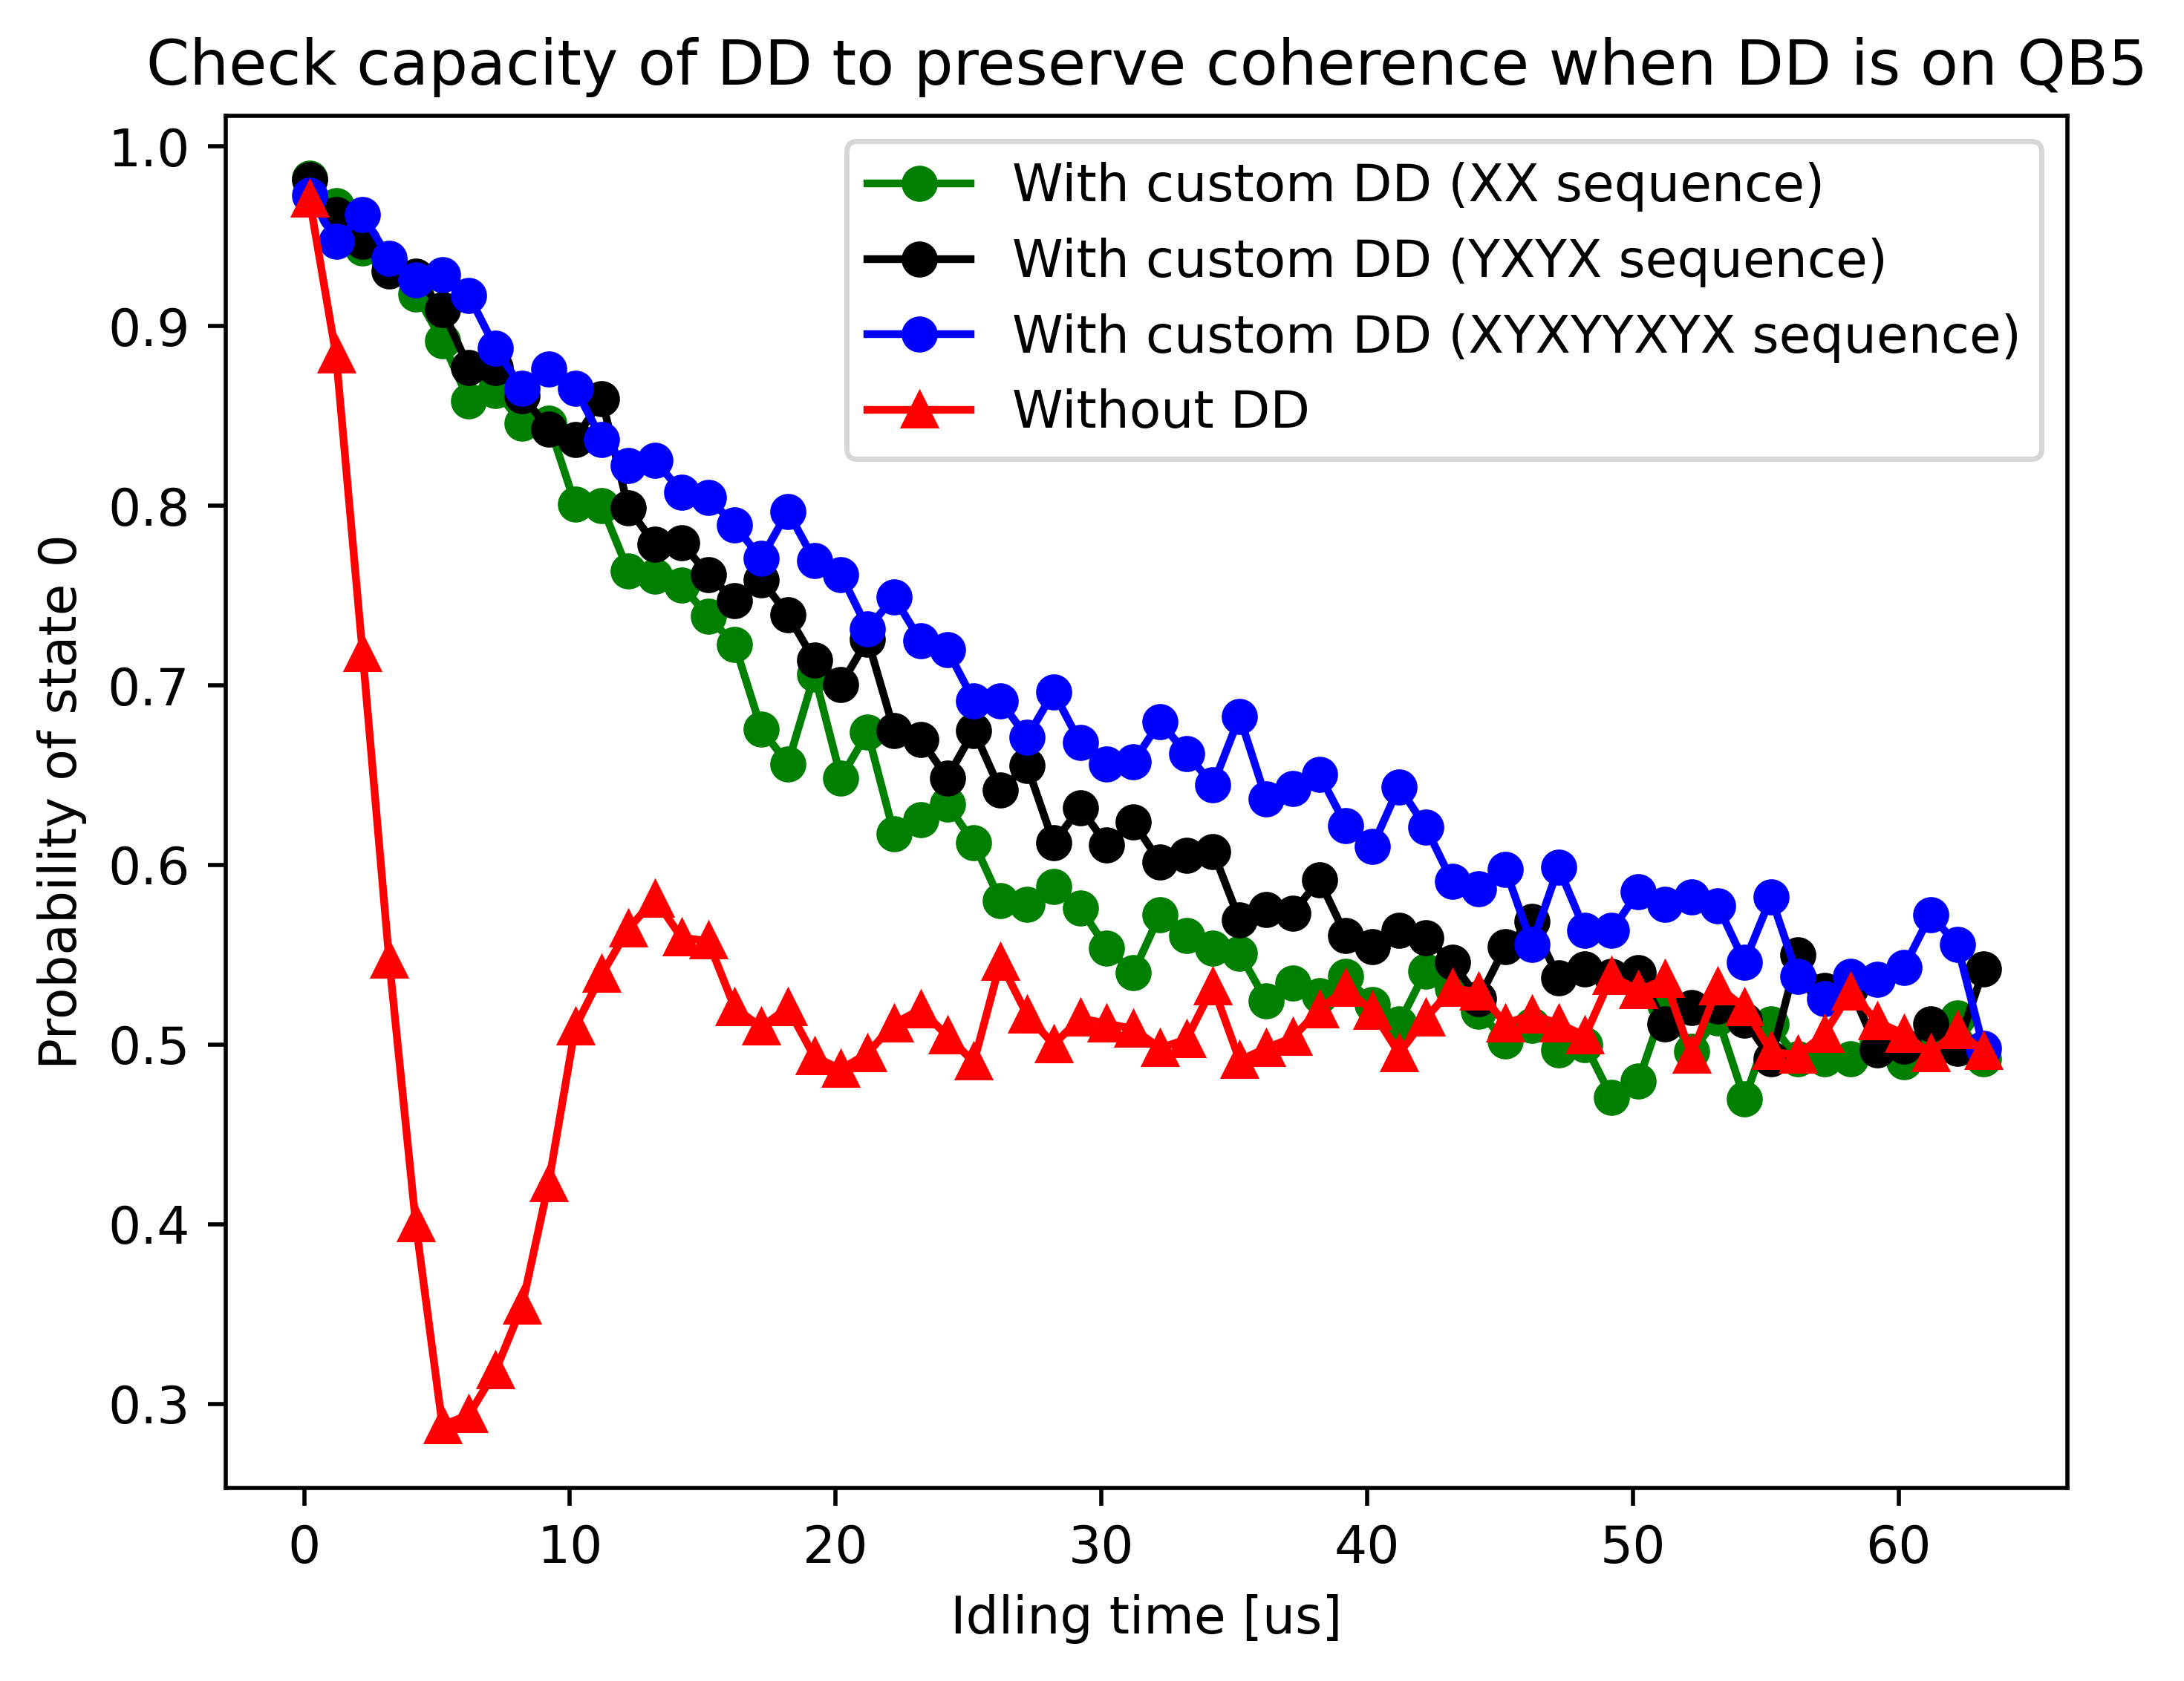

In [ ]:
print("Retrieving custom DD")
prob_dd_xx = [x['0'] for x in job_dd_xx]

personal_job_dd_probs = [x['0'] for x in my_personal_job_dd]

plt.plot(time_array, prob_dd_xx, 'go-', label="With custom DD (XX sequence)")
plt.plot(time_array, personal_job_dd_probs, 'bo-', label="Name your sequence here")
plt.plot(time_array, prob_bare, 'r^-', label="Without DD")
plt.xlabel("Idling time [us]")
plt.ylabel("Probability of state 0")
plt.title("Check capacity of DD to preserve coherence when DD is on the selected qubits")
plt.legend()
plt.show()

As you can see, depending on the DD sequences, higher or lower error suppression is seen. 
**Task: Create a custom strategy for the DD sequences. Compare the performance of the standard and custom strategies. Make sure, your's is outperform the existing strategies.**

# We can customise the DD sequences further by also changing the phases of individual DD pulse

One can further customise the DD sequences by also tuning not just the polar angle of SQG pulses on the Bloch sphere but azimuthal angles too, as shown below. Tuning both θ and ϕ gives flexibility to create more advanced sequences such as the Universally Robust (UR) sequence [1]. 

In [ ]:
gate_sequences = [
    (np.pi, 0),
    (np.pi, np.pi / 2),
    (np.pi, 0),
    (np.pi, np.pi / 2),
    (np.pi, np.pi / 2),
    (np.pi, 0),
    (np.pi, np.pi / 2),
    (np.pi, 0),
] #This is equivalent to 'XYXYYXYX' sequence

comp_options_angles = CircuitCompilationOptions(dd_mode=DDMode.ENABLED, dd_strategy=DDStrategy(gate_sequences=[(8, gate_sequences, 'center')]))

**Task: Now, repeat the above with two different qubits. Make sure to choose one qubit pair with low T2 times and one qubit pair with high T2 times. Does it work better for one pair than the other?**

# Conclusion

Depending on the error profile of the QPU, DD is good at suppressing errors. The effectiveness of DD sequences depends fundamentally on their interaction with the error Hamiltonian. For a QPU with dominant Pauli error channels, we can analyze suppression below:

### Key Mathematical Insights:

1. **XX Sequence Properties**:
   - Perfect suppression of Z/ZZ errors: 
     * XZX = -Z ⇒ ⟨Z⟩_DD ≈ Z + XZX = 0 over one cycle
     * Similarly, XZZX = -ZZ ⇒ ⟨ZZ⟩_DD = 0
   - No X-error suppression: 
     * XXX = X ⇒ ⟨X⟩_DD = X remains unchanged

2. **XYXY Universal Sequence**:
   - Higher-order cancellation via nested anti-commutation:
     * XXYXXXY = -X (using {X,Y}=0)
     * Similarly cancels Y and Z errors to 1st order

3. **Universally Robust (UR) Sequences**:
   - UR sequences can be generated by tuning both θ and ϕ of the DD pulse. This flexibility is allowed by our API as we saw at the end of this tutorial.
   - One can also achieve higher-order suppression via:
     * Concatenated sequences
     * Non-uniform pulse timing, etc.

# Citation

[1] Ezzell, N., Pokharel, B., Tewala, L., Quiroz, G., & Lidar, D. A. (2023). Dynamical decoupling for superconducting qubits: A performance survey. Physical Review Applied, 20(6), 064027.

In [ ]:

# Copyright 2025 IQM Quantum Computers (José Diogo da Costa Guimarães, Manish Thapa, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.